Notes:
concatinate data
pd.concat([df1,df2],axis=1)



https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AR.select_order.html
    

In [26]:
import time
import datetime
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly

import scipy.stats as stats
import sklearn
import os
import warnings 
#from fbprophet import Prophet 


pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

warnings.filterwarnings('ignore')



In [27]:
#import the weather data into a dataframe 
weather_data_PHL= pd.read_csv('/Users/robertshiles/CSV_files/weather_data_KPHL.csv')#,encoding= 'latin1')

#import hourly power consumption CSV
power = pd.read_csv('/Users/robertshiles/CSV_files/pjm_hourly_est.csv',encoding= 'latin1')
#weather_data_PHL

In [29]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178262 entries, 0 to 178261
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  178262 non-null  object 
 1   AEP       121273 non-null  float64
 2   COMED     66497 non-null   float64
 3   DAYTON    121275 non-null  float64
 4   DEOK      57739 non-null   float64
 5   DOM       116189 non-null  float64
 6   DUQ       119068 non-null  float64
 7   EKPC      45334 non-null   float64
 8   FE        62874 non-null   float64
 9   NI        58450 non-null   float64
 10  PJME      145366 non-null  float64
 11  PJMW      143206 non-null  float64
 12  PJM_Load  32896 non-null   float64
dtypes: float64(12), object(1)
memory usage: 17.7+ MB


In [28]:
weather_data_PHL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228394 entries, 0 to 228393
Data columns (total 47 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   key                        228394 non-null  object 
 1   class                      228394 non-null  object 
 2   date/time                  228394 non-null  object 
 3   expire_time_gmt            228394 non-null  int64  
 4   obs_id                     228394 non-null  object 
 5   obs_name                   228394 non-null  object 
 6   valid_time_gmt             228394 non-null  int64  
 7   day_ind                    228394 non-null  object 
 8   temp                       228104 non-null  float64
 9   wx_icon                    228346 non-null  float64
 10  icon_extd                  228369 non-null  float64
 11  wx_phrase                  228346 non-null  object 
 12  pressure_tend              59607 non-null   float64
 13  pressure_desc              59

In [5]:
#create a seperate column for date time to use for merging other data 
power['Datetimecolumn'] = pd.to_datetime(power['Datetime'])

#convert power to date time index and remove all columns except pjme
power['Datetime'] = pd.to_datetime(power['Datetime'])
power = power.drop(['AEP', 'COMED',
                    'DAYTON', 'DEOK',
                    'DOM', 'DUQ', 'EKPC', 'FE', 'NI','PJMW', 'PJM_Load'], axis=1 )
power = power.set_index('Datetime')
power = power.dropna(subset=['PJME'])

#drop all null values for temperature 
# this will remove duplicate weather readings 
weather_data_PHL = weather_data_PHL.dropna(subset=['temp'])

#convert weather to date time index
weather_data_PHL['DateTime'] = pd.to_datetime(weather_data_PHL['date/time'])

#drop all excessive weather information 
weather_data_PHL = weather_data_PHL.drop(['expire_time_gmt','valid_time_gmt',
                                          'wx_icon', 'icon_extd',
                                          'qualifier', 'qualifier_svrty',
                                          'blunt_phrase', 'terse_phrase',
                                          'water_temp', 'primary_wave_period',
                                          'primary_wave_height', 'primary_swell_period',
                                          'primary_swell_height', 'primary_swell_direction',
                                          'secondary_swell_period', 'secondary_swell_height',
                                          'secondary_swell_direction', 'time_dif'], axis=1 )

#set the weather to date time 
weather_data_PHL = weather_data_PHL.set_index('DateTime')



In [6]:
#check the power dataframe for null and missing values 
missingpowerdates = pd.date_range(start = power.first_valid_index(), end = power.last_valid_index() ).difference(power.index)
null_powerdates = power['PJME'].loc[power.PJME.isnull() == True].count()
print(missingpowerdates)
print('the number of missing dates is {}'.format(len(missingpowerdates)))
print('the number of null values is {}'.format(null_powerdates))

pivoted = power.pivot_table('PJME', index =power.index.date,columns =power.index.time )
pivoted.count()
# below in the index we can see that there are several missing values between midnight and 4am
#this is due to daylight savings time

DatetimeIndex([], dtype='datetime64[ns]', freq=None)
the number of missing dates is 0
the number of null values is 0


00:00:00    6057
01:00:00    6058
02:00:00    6046
03:00:00    6041
04:00:00    6058
05:00:00    6058
06:00:00    6058
07:00:00    6058
08:00:00    6058
09:00:00    6058
10:00:00    6058
11:00:00    6058
12:00:00    6058
13:00:00    6058
14:00:00    6058
15:00:00    6058
16:00:00    6058
17:00:00    6058
18:00:00    6058
19:00:00    6058
20:00:00    6058
21:00:00    6058
22:00:00    6058
23:00:00    6058
dtype: int64

In [7]:
#create an hourly date range the same size as the PJME dataset
# this will be for storing the resampled weather data 
dates = pd.date_range(start=power.first_valid_index(),end=power.last_valid_index(),freq='H')
New_weather_data_PHL = pd.DataFrame(dates).set_index(dates)

#Resample the weather data for every hour to remove duplicate data points 
New_weather_data_PHL['temp'] = weather_data_PHL['temp'].resample('H').mean()

# interpoplate missing values using slinear interpolation 
New_weather_data_PHL = New_weather_data_PHL.assign(InterpolateSLinear=New_weather_data_PHL.temp.interpolate(method='slinear'))

# display the new dataframe 
New_weather_data_PHL.head()

,0,temp,InterpolateSLinear
2002-12-31 01:00:00,2002-12-31 01:00:00,41.0,41.0
2002-12-31 02:00:00,2002-12-31 02:00:00,41.0,41.0
2002-12-31 03:00:00,2002-12-31 03:00:00,40.0,40.0
2002-12-31 04:00:00,2002-12-31 04:00:00,41.0,41.0
2002-12-31 05:00:00,2002-12-31 05:00:00,41.0,41.0


In [8]:
# check for null and missing values in the cleaned weather data 
missingpowerdates = pd.date_range(start = New_weather_data_PHL.first_valid_index(), end = New_weather_data_PHL.last_valid_index() ).difference(New_weather_data_PHL.index)
null_powerdates = New_weather_data_PHL['temp'].loc[New_weather_data_PHL.temp.isnull() == True].count()
print(missingpowerdates)
print('the number of missing dates is {}'.format(len(missingpowerdates)))
print('the number of null values is {}'.format(null_powerdates))

pivoted = New_weather_data_PHL.pivot_table('temp', index =New_weather_data_PHL.index.date,columns =New_weather_data_PHL.index.time )
pivoted.count()

DatetimeIndex([], dtype='datetime64[ns]', freq=None)
the number of missing dates is 0
the number of null values is 0


00:00:00    5444
01:00:00    5453
02:00:00    5458
03:00:00    5453
04:00:00    5460
05:00:00    5443
06:00:00    5430
07:00:00    5430
08:00:00    5434
09:00:00    5435
10:00:00    5441
11:00:00    5445
12:00:00    5442
13:00:00    5441
14:00:00    5441
15:00:00    5445
16:00:00    5449
17:00:00    5450
18:00:00    5445
19:00:00    5431
20:00:00    5441
21:00:00    5446
22:00:00    5447
23:00:00    5448
dtype: int64

In [9]:
power = power.merge(New_weather_data_PHL['InterpolateSLinear'],how = 'left',left_on='Datetimecolumn', right_index=True)
power.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   PJME                145366 non-null  float64       
 1   Datetimecolumn      145366 non-null  datetime64[ns]
 2   InterpolateSLinear  131521 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.4 MB


In [25]:
power.head(40)

,PJME,Datetimecolumn,InterpolateSLinear
Datetime,,,
2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,41.000000
2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,41.000000
2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,40.000000
2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,41.000000
2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,41.000000
2002-12-31 06:00:00,26222.0,2002-12-31 06:00:00,42.000000
2002-12-31 07:00:00,28702.0,2002-12-31 07:00:00,42.500000
2002-12-31 08:00:00,30698.0,2002-12-31 08:00:00,42.000000
2002-12-31 09:00:00,31800.0,2002-12-31 09:00:00,42.666667


In [10]:
#create an array of the PJME values
elect = []
elect = power['PJME'].dropna().tolist()

#create an array of temperature values
temp = []
temp = power['InterpolateSLinear'].dropna().tolist()
print(len(elect))

145366


In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
train = elect
#train = power['total']
result_elect = seasonal_decompose(elect,model = 'additive', freq = (168))

result_temp = seasonal_decompose(temp,model = 'additive', freq = (168))

#result = seasonal_decompose(train,model = 'multiplicative', freq = (8766))
#resultweekly = seasonal_decompose(train,model = 'additive', freq = (168))



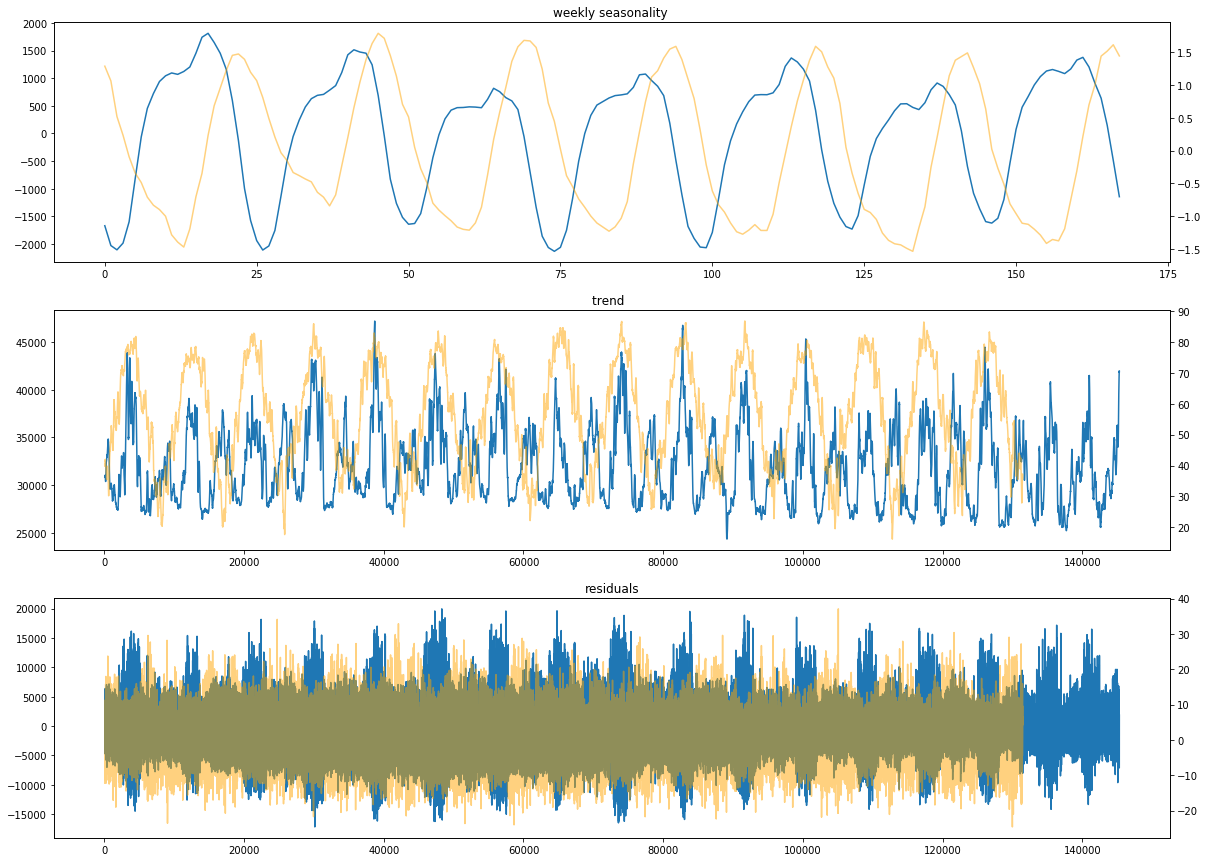

In [12]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.plot(result_elect.seasonal[0:168])
plt.title('weekly seasonality ')
plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.plot(result_temp.seasonal[0:168], color = 'orange',alpha =.5)

plt.subplot(3,1,2)
plt.plot(result_elect.trend)
plt.title('trend  ')
plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.plot(result_temp.trend, color = 'orange',alpha =.5)

plt.subplot(3,1,3)
plt.plot(result_elect.resid)
plt.title('residuals')
plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.plot(result_temp.resid, color = 'orange',alpha =.5)

plt.show()

In [13]:
elect2 = result_elect.trend+result_elect.resid
print(len(elect2))
elect2 = elect2[np.logical_not(np.isnan(elect2))]
print(elect2)
print('the lenght of the array is now{}'.format(len(elect2)))

temp2 = result_temp.trend+result_temp.resid
print(len(temp2))
temp2 = temp2[np.logical_not(np.isnan(temp2))]
print(temp2)
print('the lenght of the array is now{}'.format(len(temp2)))

145366
[30569.99086321 29806.38382702 29215.12739638 ... 43145.2415892
 43699.19368801 43803.12300263]
the lenght of the array is now145198
131521
[28.16175572 29.3648177  33.77851911 ... 42.16482603 42.19966953
 42.21228142]
the lenght of the array is now131353


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result2_elect = seasonal_decompose(elect2,model = 'additive', freq = (8766))

result2_temp = seasonal_decompose(temp2,model = 'additive', freq = (8766))

#result = seasonal_decompose(train,model = 'multiplicative', freq = (8766))
#resultweekly = seasonal_decompose(train,model = 'additive', freq = (168))



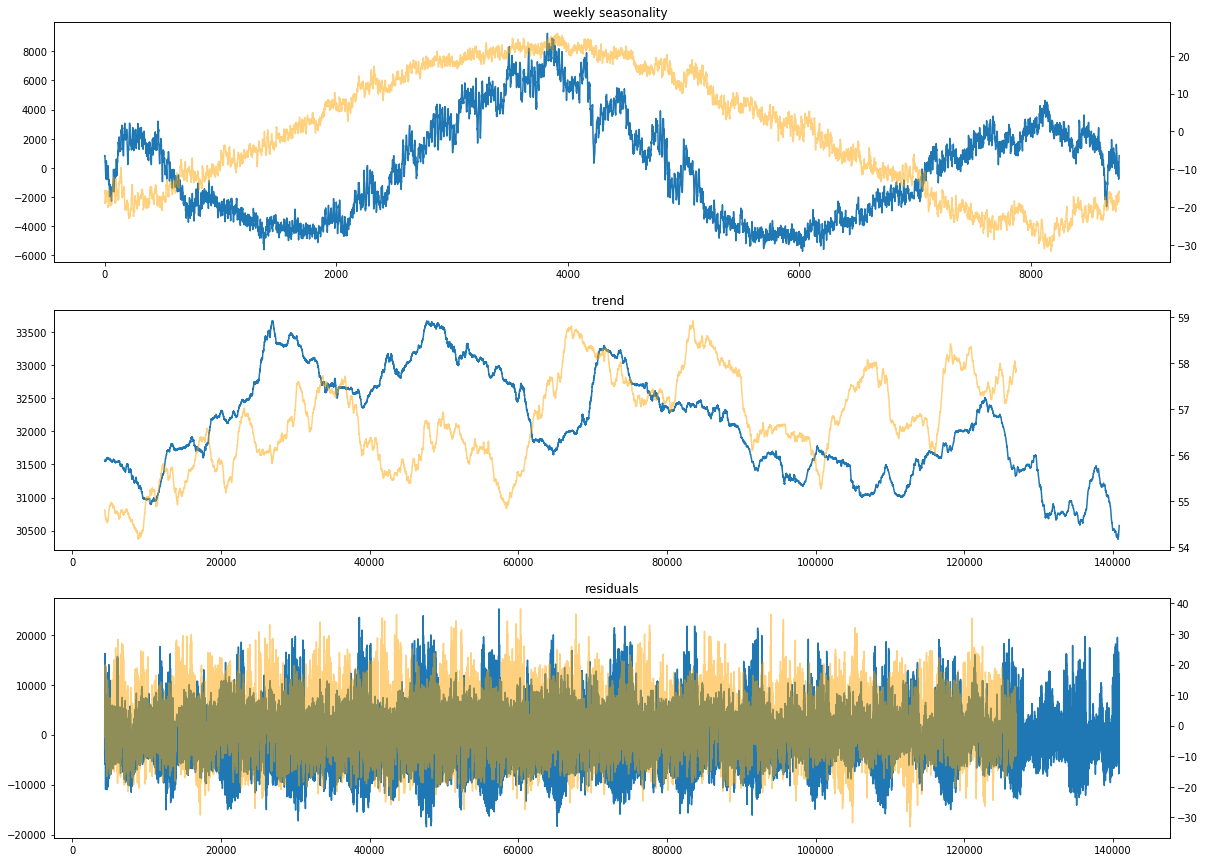

In [15]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.plot(result2_elect.seasonal[0:8766])
plt.title('weekly seasonality ')
plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.plot(result2_temp.seasonal[0:8766], color = 'orange',alpha =.5)

plt.subplot(3,1,2)
plt.plot(result2_elect.trend)
plt.title('trend  ')
plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.plot(result2_temp.trend, color = 'orange',alpha =.5)

plt.subplot(3,1,3)
plt.plot(result2_elect.resid)
plt.title('residuals')
plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.plot(result2_temp.resid, color = 'orange',alpha =.5)

plt.show()

In [16]:
print(result2_temp.resid)

[nan nan nan ... nan nan nan]


In [17]:

from statsmodels.tsa.stattools import adfuller


elecResiduals = np.sort(result2_elect.resid[np.logical_not(np.isnan(result2_elect.resid))])
elecresid_min = elecResiduals.min()
elecresid_max = elecResiduals.max()
elecresid_len = len(elecResiduals)
elecresid_std = np.std(elecResiduals)
elecresid_avg = np.mean(elecResiduals)

print('the Minimum is {}'.format(elecresid_min))
print('the Maximum is {}'.format(elecresid_max))
print('the Length is {}'.format(elecresid_len))
print('the Length is {}'.format(elecresid_len))
print('the Standard Deviation is {}'.format(elecresid_std))
print('the Mean is {}'.format(elecresid_avg))
print('\n')


#X = elecResiduals
X = result2_elect.resid[np.logical_not(np.isnan(result2_elect.resid))]
fuller_result = adfuller(X)
print('ADF Statistic: %f' % fuller_result[0])
print('p-value: %f' % fuller_result[1])
print('Critical Values:')
for key, value in fuller_result[4].items():
    print('\t%s: %.3f' % (key, value))

the Minimum is -18463.92546741339
the Maximum is 25179.283070853646
the Length is 136432
the Length is 136432
the Standard Deviation is 5342.487838590738
the Mean is -9.707348234170242


ADF Statistic: -32.863032
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


the p value is zero and we reject the null hypothesis that a unit root is present in the time series therfore we can assume that the series is stationary 

for Augmented Dicky fuller 
tests the null hypothesis that a unit root is present in a time series sample.Unit root tests are tests for stationarity in a time series. A time series has stationarity if a shift in time doesn’t cause a change in the shape of the distribution; unit roots are one cause for non-stationarity.
The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.



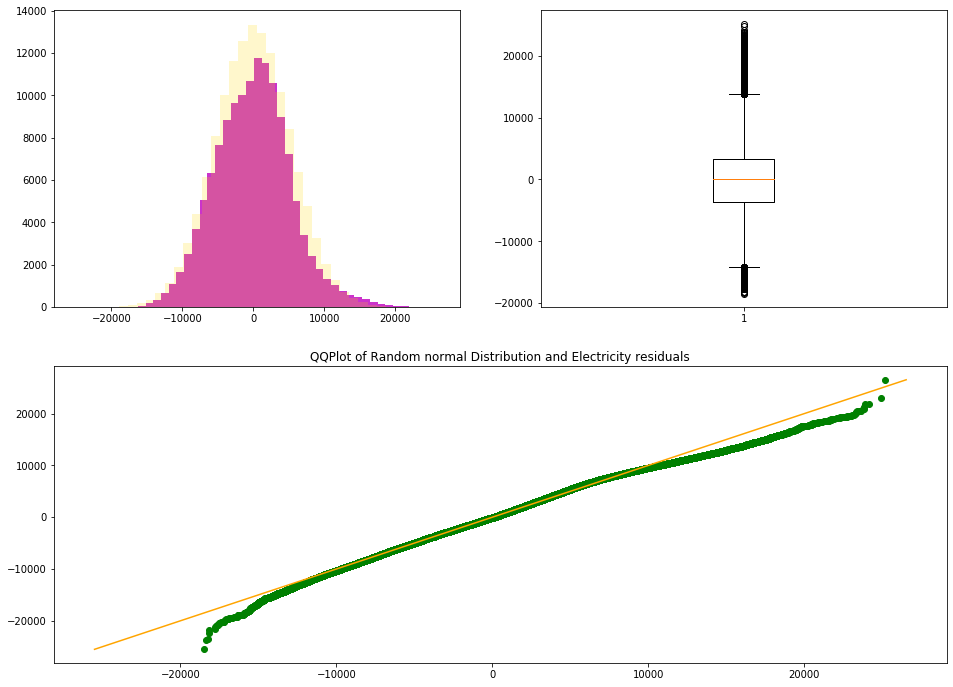

the Jarque berra stat is 2086.2611960746754, and the pvalue is 0.0
NormaltestResult(statistic=1802.445017159314, pvalue=0.0)


In [18]:
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest


# input the mean, standard deviation and lenght of the residuals
normal = np.random.normal(np.mean(elecResiduals), np.std(elecResiduals), len(elecResiduals))

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.hist(elecResiduals,bins=40,color = 'm',alpha = 0.8)
plt.hist(normal,bins=40,color = 'gold', alpha = 0.2)

#Generate a Box Plot of solar system counts
plt.subplot(2, 2, 2)
plt.boxplot(elecResiduals)

#Generate a QQ plot of the gamma distribution and the solar system counts 
plt.subplot(2, 1, 2)
orderd_normal = sorted(normal)
ordered_data=elecResiduals
plt.scatter(ordered_data,orderd_normal, color = 'green')
plt.plot(orderd_normal,orderd_normal,color= 'orange')
plt.title('QQPlot of Random normal Distribution and Electricity residuals')
plt.show()

jb_stats = jarque_bera(elecResiduals)
norm_stats = normaltest(elecResiduals)
print('the Jarque berra stat is {}, and the pvalue is {}'.format(jb_stats[0],jb_stats[1]))
print(norm_stats)



In [19]:
from statsmodels.tsa.stattools import adfuller

tempResiduals = np.sort(result2_temp.resid[np.logical_not(np.isnan(result2_temp.resid))])
tempresid_min = tempResiduals.min()
tempresid_max = tempResiduals.max()
tempresid_len = len(tempResiduals)
tempresid_std = np.std(tempResiduals)
tempresid_avg = np.mean(tempResiduals)

print('the Minimum is {}'.format(tempresid_min))
print('the Maximum is {}'.format(tempresid_max))
print('the Length is {}'.format(tempresid_len))
print('the Length is {}'.format(tempresid_len))
print('the Standard Deviation is {}'.format(tempresid_std))
print('the Mean is {}'.format(tempresid_avg))

X = result2_temp.resid[np.logical_not(np.isnan(result2_temp.resid))]
fuller_result = adfuller(X)
print('ADF Statistic: %f' % fuller_result[0])
print('p-value: %f' % fuller_result[1])
print('Critical Values:')
for key, value in fuller_result[4].items():
    print('\t%s: %.3f' % (key, value))

the Minimum is -33.11502378381108
the Maximum is 38.20001073638821
the Length is 122587
the Length is 122587
the Standard Deviation is 8.669209446015387
the Mean is -0.03318539450772202
ADF Statistic: -27.290726
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


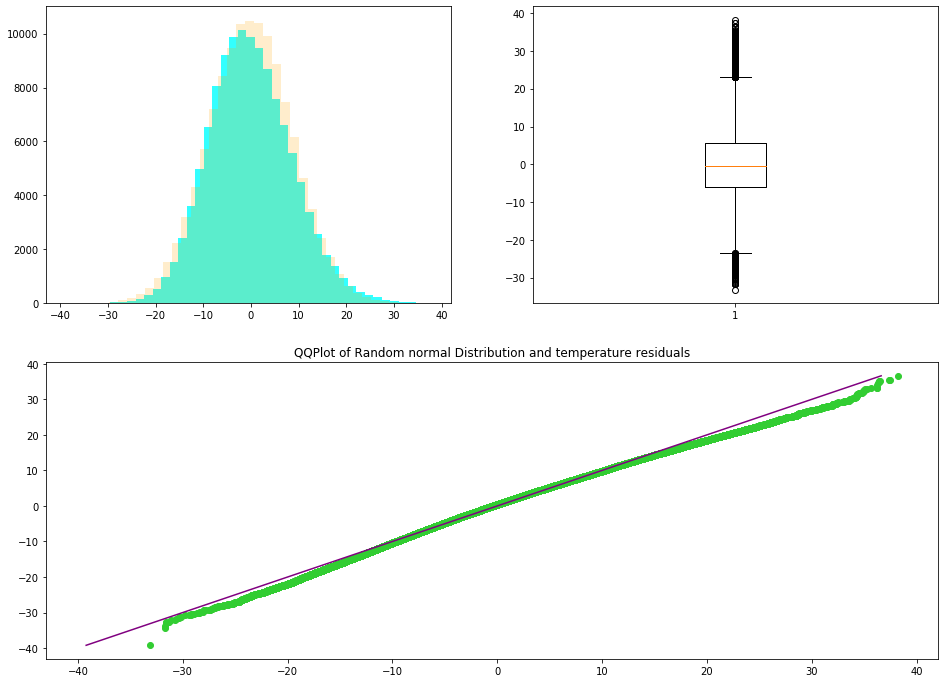

the Jarque berra stat is 1744.8560699495893, and the pvalue is 0.0
NormaltestResult(statistic=1668.7620288986227, pvalue=0.0)


In [20]:
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest


# input the mean, standard deviation and lenght of the residuals
normal = np.random.normal(np.mean(tempResiduals), np.std(tempResiduals), len(tempResiduals))

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.hist(tempResiduals,bins=40,color = 'cyan',alpha = 0.8)
plt.hist(normal,bins=40,color = 'orange', alpha = 0.2)

#Generate a Box Plot of solar system counts
plt.subplot(2, 2, 2)
plt.boxplot(tempResiduals)

#Generate a QQ plot of the gamma distribution and the solar system counts 
plt.subplot(2, 1, 2)
orderd_normal = sorted(normal)
ordered_data=tempResiduals
plt.scatter(ordered_data,orderd_normal, color = 'limegreen')
plt.plot(orderd_normal,orderd_normal,color= 'purple')
plt.title('QQPlot of Random normal Distribution and temperature residuals')
plt.show()

jb_stats = jarque_bera(tempResiduals)
norm_stats = normaltest(tempResiduals)
print('the Jarque berra stat is {}, and the pvalue is {}'.format(jb_stats[0],jb_stats[1]))
print(norm_stats)



Before break down into 

In [21]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

temp_data = []
elec_data = []
temp_data = result2_temp.resid[np.logical_not(np.isnan(result2_temp.resid))]
elec_data = result2_elect.resid[np.logical_not(np.isnan(result2_elect.resid))]

data_matrix = []
#for i in range(0,len(temp_data)):
 #   data_matrix.append([elec_data[i],temp_data[i]])
#data_matrix = pd.DataFrame(elec_data,temp_data)

data_matrix = np.column_stack((elec_data[0:len(temp_data)], temp_data))

print(data_matrix)

[[-4.14947612e+03 -8.65949852e-01]
 [-3.41981742e+03 -1.75759205e+00]
 [-1.69009563e+03 -1.70536365e+00]
 ...
 [-4.75909375e+03  8.60781778e-03]
 [-4.72137159e+03 -6.16833758e-02]
 [-4.25085379e+03  4.91830547e-01]]


In [22]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
# make a VAR model
model = VAR(data_matrix)

In [23]:
# using lag 2 
results = model.fit(2)

results.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 14, Jun, 2020
Time:                     14:08:35
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.5539
Nobs:                     122585.    HQIC:                   15.5533
Log likelihood:      -1.30116e+06    FPE:                5.68367e+06
AIC:                      15.5531    Det(Omega_mle):     5.68321e+06
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.121708         2.825949            0.043           0.966
L1.y1         1.663675         0.001909          871.592           0.000
L1.y2        14.813317         1.149261           12.889           0.000
L2.y1        -0.737985

In [2]:
results.residuals()


NameError: name 'results' is not defined